<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/inverseProblems/neuralDemosaicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Demosaicing Notebook
## David Brady
## University of Arizona

This notebook implements a demosaicing network using the cifar10 database for training. 

Task include: 

1. load cifar10 images into the notebook
2. create the network. The input to the network is an [32 32 3] image. The first layer transforms the [32 32 3 ] image into a [16 16 4] sampled image with fixed weights according to the color filter. The network should then be a multilayer u net to transform this image back into the original RGB image. 

The first layer implements the bayer filter and is not trainable. Subsequent layers implement a variational auto encoder in an attempt to recover the originalimage. 


 

### Load modules

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy import interpolate as interp
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
tf.experimental_relax_shapes=True

### load  and prep CIFAR10 dataset

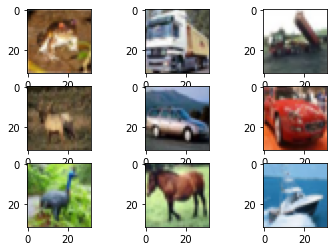

In [5]:

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# Normalize data
# Normalize and reshape the data
trainX=trainX.astype("float32")/255.0
testX=testX.astype("float32")/255.0
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i])
# show the figure
plt.show()

### Color sampling functions

In [3]:

#This is the filter array for Bayer color sampling
def bayerCFA(shape,dtype='none'):
    kernel = np.array([[[1,0,0],[0,0,0]],[[0,0,0],[0,0,0]]])
    kernel = np.stack((kernel,np.array([[[0,0,0],[0,1,0]],[[0,0,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,1,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,0,0],[0,0,1]]] )),axis=-1)
    return kernel

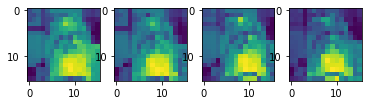

In [4]:
# This network transforms a 32 by 32 color image into a 16 by 16 by 4 bayer sample array 
inputs = layers.Input(shape=(32,32,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
cfaSample=Model(inputs,cfa)
dog=cfaSample.predict(testX[5101,:,:,:].reshape(1,32,32,3))
for pop in range(4):
  plt.subplot(1,4,1+pop)
  plt.imshow(dog[0,:,:,pop])

In [ ]:
def linearDemosaic(bayerImage):
  # transform 16 by 16 by 4 image into 32 by 32 by 3 rbg by linear interpolation
    redU=interp.RectBivariateSpline(np.arange(0,16),np.arange(0,16),bayerImage[0,:,:,0])
    red=redU(np.arange(0,16,.5),np.arange(0,16,.5))
    blueU=interp.RectBivariateSpline(np.arange(0,16),np.arange(0,16),bayerImage[0,:,:,3])
    blue=blueU(np.arange(0,16,.5),np.arange(0,16,.5))
    green=np.zeros((32,32))
    green[0:32:2,1:32:2]=bayerImage[0,:,:,1]
    green[1:32:2,0:32:2]=bayerImage[0,:,:,2]
    green[0:32:2,0:32:2]=(green[0:32:2,1:32:2]+green[0:32:2,1:32:2])/2
    green[1:32:2,1:32:2]=(green[0:32:2,1:32:2]+green[0:32:2,1:32:2])/2
    imageOut=np.dstack((red,green,blue))
    imageOut=255*imageOut/np.max(imageOut)
    imageOut=imageOut.astype(np.uint8)
    return imageOut



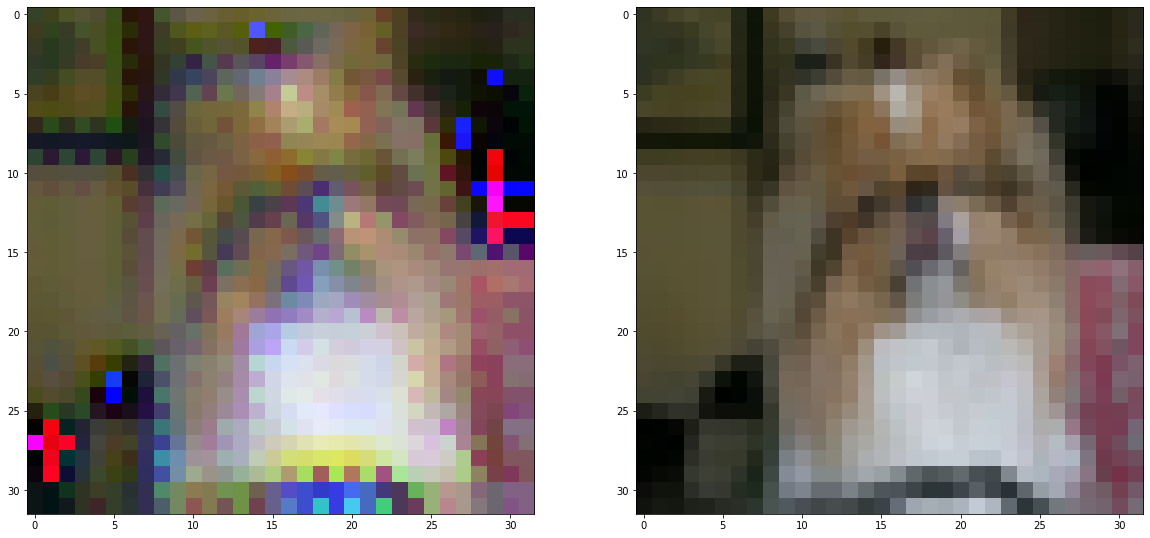

In [ ]:
dig=linearDemosaic(dog)
plt.subplot(1,2,1)
plt.imshow(dig)
plt.subplot(1,2,2)
plt.imshow(testX[5101,:,:,:])

## Test networks

#### autoencoder

The auto encoder structure is copied from 

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/autoencoder.ipynb

In [9]:
inputs = layers.Input(shape=(32,32,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
# Encoder
x = layers.Conv2D(16, (2, 2), strides=2, activation="relu", padding="same")(cfa)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.layers[1].trainable= False
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 4)         48        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 8)         1160

The compression ratio is about 6

In [8]:
32*32*3

3072

In [10]:
4*4*32

512

##### train the model

In [13]:
autoencoder.fit(
    x=trainX,
    y=trainX,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(testX, testX),
)

Epoch 1/20
391/391 [==============================] - 3s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0019 - val_loss: 0.0019

In [14]:
dog=autoencoder.predict(testX[5100,:,:,:].reshape(1,32,32,3))

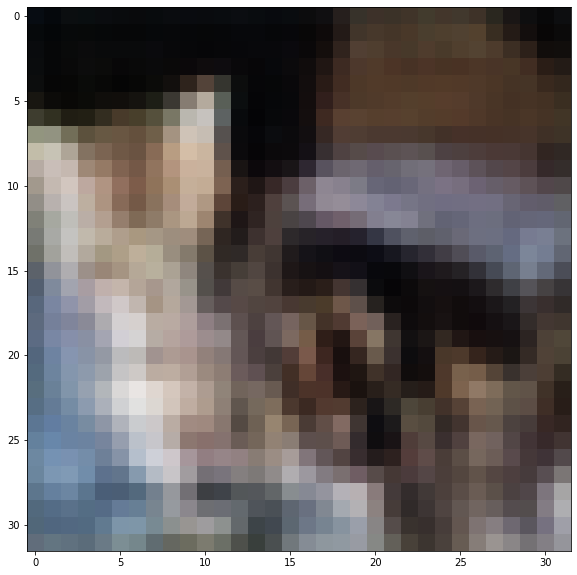

In [15]:
plt.imshow((255*dog[0,:,:,:]).astype(int))

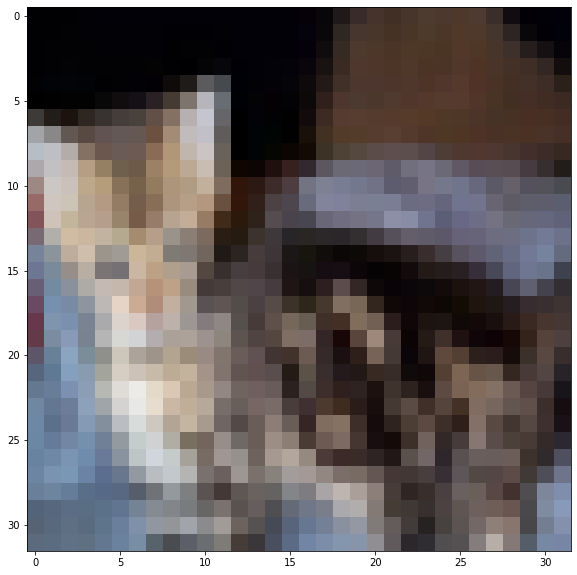

In [ ]:
plt.imshow(testX[5100,:,:,:])

#### autoencoder with residuals

In [29]:
inputs = layers.Input(shape=(32,32,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation="relu", padding="same")(cfa)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(x1)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3),  activation="relu", padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x1])
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,cfa])
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.layers[1].trainable= False
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 16, 16, 4)    48          input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 8, 8, 16)     272         conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 4, 4, 32)     4640        conv2d_42[0][0]                  
___________________________________________________________________________________________

##### train the model

In [31]:
autoencoder.fit(
    x=trainX,
    y=trainX,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(testX, testX),
)

Epoch 1/20
391/391 [==============================] - 4s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 2/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/20
391/391 [==============================] - 4s 9ms/step - loss: 0.0012 - val_loss: 0.001

In [32]:
dog=autoencoder.predict(testX[5100,:,:,:].reshape(1,32,32,3))

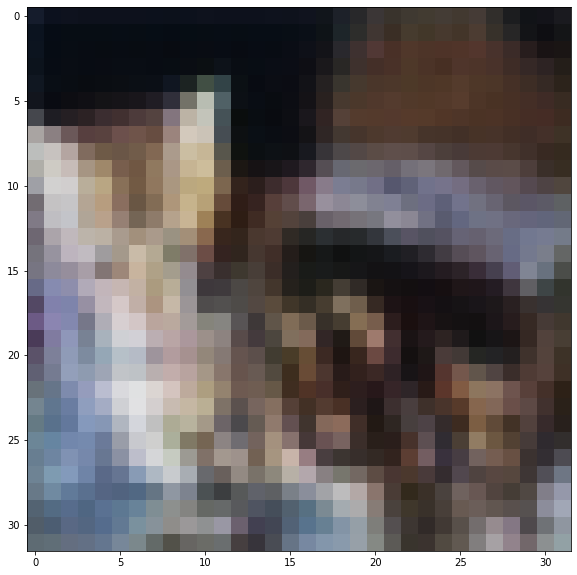

In [33]:
plt.imshow((255*dog[0,:,:,:]).astype(int))

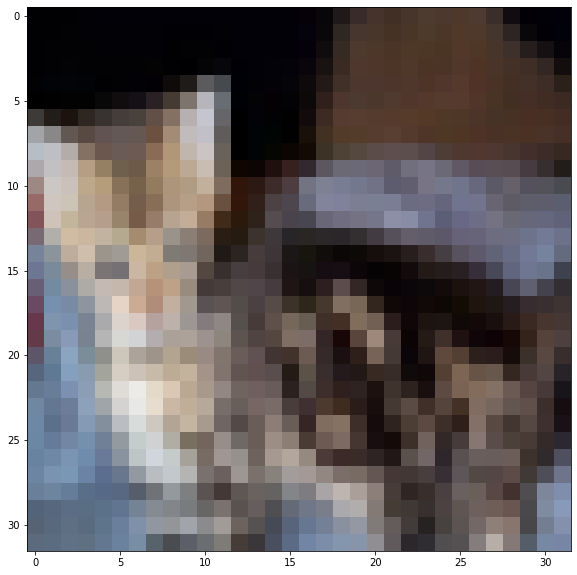

In [ ]:
plt.imshow(testX[5100,:,:,:])

#### simple convolutional network

In [ ]:
inputs = layers.Input(shape=(32,32,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
# convlutonal network
x = layers.Conv2D(16, (2, 2), activation="relu", padding="same")(cfa)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# covnet
covnet = Model(inputs, x)
covnet.layers[1].trainable= False
covnet.compile(optimizer="adam", loss="mean_squared_error")
covnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 4)         48        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        272       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 8)         584 

In [ ]:
covnet.fit(
    x=trainX,
    y=trainX,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(testX, testX),
)

Epoch 1/20
391/391 [==============================] - 3s 7ms/step - loss: 0.0010 - val_loss: 9.7892e-04
Epoch 2/20
391/391 [==============================] - 3s 7ms/step - loss: 9.9604e-04 - val_loss: 9.5169e-04
Epoch 3/20
391/391 [==============================] - 3s 7ms/step - loss: 9.7956e-04 - val_loss: 9.6100e-04
Epoch 4/20
391/391 [==============================] - 3s 7ms/step - loss: 9.7314e-04 - val_loss: 9.3529e-04
Epoch 5/20
391/391 [==============================] - 3s 7ms/step - loss: 9.8075e-04 - val_loss: 9.3086e-04
Epoch 6/20
391/391 [==============================] - 3s 7ms/step - loss: 9.4832e-04 - val_loss: 9.0080e-04
Epoch 7/20
391/391 [==============================] - 3s 7ms/step - loss: 9.3390e-04 - val_loss: 9.4152e-04
Epoch 8/20
391/391 [==============================] - 3s 7ms/step - loss: 9.2675e-04 - val_loss: 8.8245e-04
Epoch 9/20
391/391 [==============================] - 3s 7ms/step - loss: 9.2781e-04 - val_loss: 8.7567e-04
Epoch 10/20
391/391 [===========

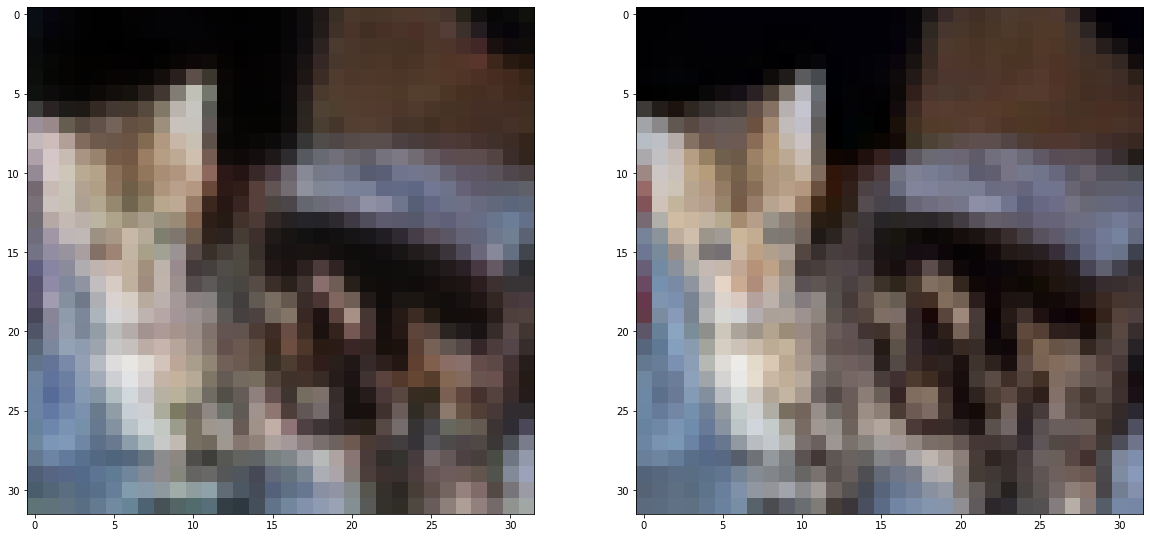

In [ ]:
dog=covnet.predict(testX[5100,:,:,:].reshape(1,32,32,3))
plt.subplot(1,2,1)
plt.imshow(dog[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(testX[5100,:,:,:])
